In [41]:
!pip install -q transformers datasets librosa

In [42]:
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [43]:
BASE_MODEL=	'ShakurovR/knv_model_v2' #'deepvk/USER-bge-m3' #"ai-forever/ruBert-base"
EMBEDDING_DIM = 1024

In [44]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [45]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [46]:
# data = load_dataset("csv", data_files={"train": "./content/train.csv", "validation": "./content/valid.csv"})
data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 69973
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [47]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'Д', '⣆', '⠀', 'ч', 'О', '̣', '⠢', 'ī', ':', '😻', '͠', '͢', '͔', 'z', '🗑', 'с', '🚓', 'Δ', '😇', 'ᴅ', '😂', '♫', '👌', 'а', 'Н', '☁', '개', '在', 'Ч', '2', 'Щ', '⣀', '💔', '😋', 'h', '̨', '😒', '👎', '👶', 'S', '≠', '⣦', 'ᴍ', '͚', '💜', '⢧', '🔥', '❄', 'А', 'f', '🦗', '▫', "'", '⡿', 'ツ', '⠴', 'С', '😑', '😛', '🙄', '🌈', '🏼', '⢠', '中', '̻', '🎾', '❣', 'З', '😿', '🍕', '🔪', '💕', '\u200d', '}', '😝', 'ų', 'П', '№', '“', '⠊', '̷', 'у', 'ñ', '병', '😰', '人', '雅', '¦', 'Э', '🇸', '͎', 'ᴡ', '🍰', '⚡', '🎖', '͏', '⣷', 'g', '⠏', '🏈', '🔑', '⚰', '⢀', '%', '🖕', '😥', '☆', '😮', '🎵', 'ß', '허', '̜', 'A', '⣹', 'ş', '♾', '⣼', 'Z', '7', 'ı', 'Ё', '9', '😫', '͜', '清', 'з', '玛', '👏', '⣤', '😬', '청', '🌱', '~', '👐', '̖', 'г', '"', 'ы', '…', '你', 'н', '⣄', '😭', '🅱', '©', '⣶', '🤗', '💲', 'Ъ', 'ʖ', '\xa0', '̠', '⠓', 'ʌ', '😱', '🇲', 'ё', '/', '😄', 'Ь', 'ц', '👉', 'ᴇ', '👋', '☺', '’', '👸', '🏊', ',', 'k', '\u200b', '🥺', 'Á', 'P', '⠶', 'ω', 'R', '⡄', '🐃', '8', '💸', '3', '🌟', '⣿', '⡇', '🤢', 'п', '💄', 'ю', '🍩', '카', '͘', '`'

#### 📊 Построим гистограммы распределения

In [48]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

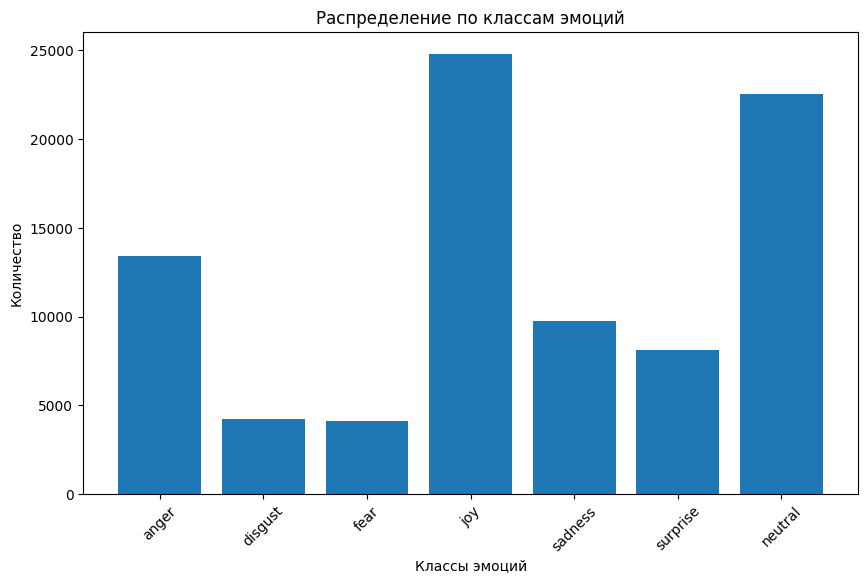

In [49]:
plot_histogram(data["train"])

In [50]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

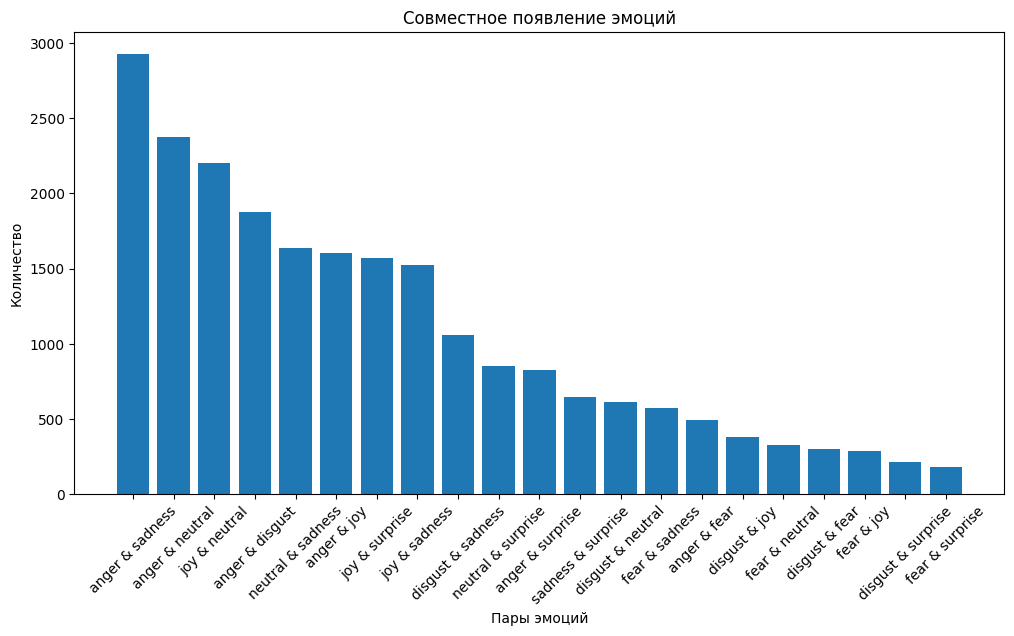

In [51]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [52]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [53]:
data = data.map(cleaner)

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [54]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

#### 🏋️ Подготовим модель

In [55]:
class Model(torch.nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.hid = torch.nn.Linear(hidden_dim, 368)
        self.fc = torch.nn.Linear(368, num_classes)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.hid(features)
        output = self.fc(output)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model=BASE_MODEL, hidden_dim=EMBEDDING_DIM, num_classes=len(labels))
model = model.to(device)

#### 📒 Подготовим данные для обучения

In [56]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [57]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/69973 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[0, 0, 0, 0, 0, 0, 1]

#### 🔗 Dataset & DataLoader

In [58]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(self.dataset[index]["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [59]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [60]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [61]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)

#### 🥷 Код для обучения и валидации

In [62]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')

    return model

In [63]:
data['train']

Dataset({
    features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral', 'input_ids', 'token_type_ids', 'attention_mask', 'one_hot_labels'],
    num_rows: 69973
})

In [64]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')

    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [65]:
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)

Epoch: 0
Train loss: 0.3159088743424939
Valid loss: 0.23903673711945028
Epoch: 1
Train loss: 0.274415633237667
Valid loss: 0.2303097351508982
Epoch: 2
Train loss: 0.2521478708363538
Valid loss: 0.2330923434566049


In [66]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels,digits=4))

Valid loss: 0.2330923434566049
              precision    recall  f1-score   support

       anger     0.5719    0.4993    0.5331       717
     disgust     0.5128    0.4124    0.4571        97
        fear     0.4412    0.5714    0.4979       105
         joy     0.8097    0.8265    0.8180      2219
     sadness     0.5480    0.7026    0.6157       390
    surprise     0.6360    0.2772    0.3862       624
     neutral     0.6863    0.5934    0.6365      1766

   micro avg     0.7008    0.6399    0.6690      5918
   macro avg     0.6008    0.5547    0.5635      5918
weighted avg     0.6971    0.6399    0.6589      5918
 samples avg     0.6601    0.6570    0.6493      5918



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ✏️ Получаем результаты на тесте

In [68]:
test = load_dataset("csv", data_files={"test": "/content/test_without_answers.csv"})

In [ ]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           return_token_type_ids=True,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

In [70]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [71]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.3490843388469929


#### 🧑‍🍳 Готовим сабмит

In [ ]:
import pandas as pd

df = pd.read_csv("/content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [ ]:
df.head()

In [ ]:
df.insert(loc=0, column='id', value=np.arange(1, len(df) + 1))
df = df.drop(['text'],axis=1)

In [ ]:
df[labels] = outputs.astype(int)

In [76]:
df.head()

,id,anger,disgust,fear,joy,sadness,surprise,neutral
0,1,0,0,0,1,0,0,0
1,2,0,0,0,1,0,0,0
2,3,0,0,0,0,0,0,0
3,4,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,1


In [77]:
df.to_csv("/content/submission_v4.csv", index=False)